# Validação das tarefas de aprendizado

## Importações

In [1]:
# -*- coding: utf-8 -*-

import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
import Orange
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare

## Parâmetros gerais

In [2]:
n_splits = 10
random_state = 17

base = pd.read_csv('student-por.csv', sep = ";")

## Tarefa de classificação

### Função de pré-processamento

In [3]:
def preprocess_class(base):

    base = base.drop(['school'], axis=1)
    
    base = base.replace(['LE3', 'GT3'], [0,1])
    
    items = ['sex', 'address','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher',
             'internet','romantic']
    
    for item in items:
        base = pd.concat([base,pd.get_dummies(base[item], prefix=item)],axis=1)
        base = base.drop([item],axis=1)
    
    base.loc[base['G3'] < 10, 'G3'] = 0
    base.loc[base['G3'] >= 10, 'G3'] = 1
    
    return base

### Função de treinamento e teste com base_class nos algoritmos escolhidos

In [4]:
def search_class(X, y, n_splits, random_state, algorithms):
    
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    perf = accuracy_score
    
    score = {}
    for algorithm in algorithms.keys():
        score[algorithm] = []
    
    for algorithm, (clf, parameters) in algorithms.items():
        for train, test in kf.split(X, y):
            prep = StandardScaler()
            prep.fit(X[train])
            best = GridSearchCV(clf, parameters, cv=gskf, scoring=make_scorer(perf))
            best.fit(prep.transform(X[train]), y[train])
            score[algorithm].append(perf(best.predict(prep.transform(X[test])), y[test]))
            
    df_metrics = pd.DataFrame.from_dict(score)
    return df_metrics

### Função que executa o teste de Friedman e Nemenyi (se necessário)

In [5]:
def friedman_nemenyi_tests_class(df_metrics, title):   
    
    df_score = df_metrics.rank(axis=1, ascending=False)
    
    stat, p = friedmanchisquare(*[grp for idx, grp in df_score.iteritems()])
    
    print('Statistics=%.3f, p=%g' % (stat, p))
    
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print("Different distributions (reject H0)")
        names = list(df_score.columns)
        avranks = df_score.mean().values.tolist()
        cd = Orange.evaluation.compute_CD(avranks, n_splits)
        Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
        plt.title(title)
        plt.show()
    return df_score

### Algoritmos e hiperparâmetros testados

In [6]:
algorithms_class = {
    "MLP": (MLPClassifier(), { "activation": ("identity", "logistic", "tanh", "relu"), "solver": ("lbfgs", "adam"), "max_iter": [1000], "random_state": [1]}), 
    "SVM": (SVC(), {"C": [1, 10], "kernel": ("linear", "rbf"), "random_state": [2]}),
    "KNN": (KNeighborsClassifier(), { "n_neighbors": [1, 3, 5] }),
    "DT" : (DecisionTreeClassifier(), { "criterion": ("gini", "entropy"), "max_depth": [5, 10, 20], "random_state": [3]}),
    "RF" : (RandomForestClassifier(), { "criterion": ("gini", "entropy"), "max_depth": [5, 10, 20], "n_estimators": [30,50,100], "random_state": [4]})
}

### Leitura da base_class, pré-processamento e definição do atributo-alvo

In [7]:
base_class = preprocess_class(base)

y = base_class['G3'].to_numpy()

### Combinação [  ]

#### Busca dos melhores modelos

In [8]:
X = base_class.drop(columns = ['G1','G2','G3']).to_numpy()
df_metrics_no_class = search_class(X,y,n_splits,random_state,algorithms_class)

###### Performance dos modelos

In [9]:
df_metrics_no_class

,MLP,SVM,KNN,DT,RF
0,0.830769,0.815385,0.800000,0.876923,0.846154
1,0.861538,0.876923,0.830769,0.846154,0.830769
2,0.815385,0.876923,0.846154,0.800000,0.861538
3,0.846154,0.861538,0.876923,0.830769,0.846154
4,0.861538,0.861538,0.830769,0.907692,0.846154
5,0.769231,0.846154,0.753846,0.815385,0.861538
6,0.861538,0.861538,0.846154,0.876923,0.861538
7,0.830769,0.861538,0.815385,0.846154,0.830769
8,0.861538,0.846154,0.815385,0.846154,0.830769
9,0.859375,0.843750,0.875000,0.890625,0.859375


In [10]:
df_metrics_no_class.mean()

MLP    0.839784
SVM    0.855144
KNN    0.829038
DT     0.853678
RF     0.847476
dtype: float64

In [11]:
df_metrics_no_class.std()

MLP    0.029913
SVM    0.018210
KNN    0.036312
DT     0.034003
RF     0.013239
dtype: float64

#### Teste de Friedman e Nemenyi (se necessário)

In [12]:
df_score_no_class = friedman_nemenyi_tests_class(df_metrics_no_class, "[ ]")

Statistics=7.474, p=0.112875
Same distributions (fail to reject H0)


### Combinação [G1]

#### Busca dos melhores modelos

In [13]:
X = base_class.drop(columns = ['G2','G3']).to_numpy()
df_metrics_G1_class = search_class(X,y,n_splits,random_state,algorithms_class)

###### Performance dos modelos

In [14]:
df_metrics_G1_class

,MLP,SVM,KNN,DT,RF
0,0.892308,0.846154,0.846154,0.892308,0.923077
1,0.923077,0.938462,0.846154,0.953846,0.923077
2,0.861538,0.861538,0.846154,0.907692,0.876923
3,0.876923,0.861538,0.876923,0.876923,0.846154
4,0.876923,0.907692,0.830769,0.861538,0.876923
5,0.830769,0.815385,0.784615,0.830769,0.830769
6,0.876923,0.846154,0.846154,0.876923,0.907692
7,0.969231,0.938462,0.830769,0.969231,0.938462
8,0.876923,0.876923,0.830769,0.923077,0.907692
9,0.890625,0.906250,0.875000,0.906250,0.921875


In [15]:
df_metrics_G1_class.mean()

MLP    0.887524
SVM    0.879856
KNN    0.841346
DT     0.899856
RF     0.895264
dtype: float64

In [16]:
df_metrics_G1_class.std()

MLP    0.036996
SVM    0.041431
KNN    0.025916
DT     0.041792
RF     0.036016
dtype: float64

#### Teste de Friedman e Nemenyi (se necessário)

Statistics=18.276, p=0.00108974
Different distributions (reject H0)


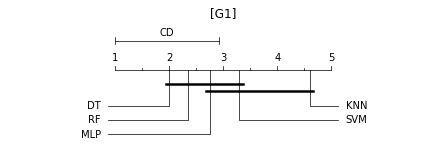

In [17]:
df_score_G1_class = friedman_nemenyi_tests_class(df_metrics_G1_class, "[G1]")

### Combinação [G2]

#### Busca dos melhores modelos

In [18]:
X = base_class.drop(columns = ['G1','G3']).to_numpy()
df_metrics_G2_class = search_class(X,y,n_splits,random_state,algorithms_class)

##### Performance dos modelos

In [19]:
df_metrics_G2_class

,MLP,SVM,KNN,DT,RF
0,0.876923,0.876923,0.846154,0.907692,0.953846
1,0.953846,0.953846,0.830769,0.938462,0.923077
2,0.892308,0.876923,0.861538,0.923077,0.938462
3,0.938462,0.923077,0.861538,0.938462,0.938462
4,0.876923,0.923077,0.815385,0.892308,0.892308
5,0.892308,0.876923,0.784615,0.830769,0.876923
6,0.876923,0.876923,0.846154,0.892308,0.923077
7,0.907692,0.892308,0.830769,0.923077,0.953846
8,0.923077,0.907692,0.815385,0.938462,0.953846
9,0.921875,0.921875,0.890625,0.921875,0.953125


In [20]:
df_metrics_G2_class.mean()

MLP    0.906034
SVM    0.902957
KNN    0.838293
DT     0.910649
RF     0.930697
dtype: float64

In [21]:
df_metrics_G2_class.std()

MLP    0.027489
SVM    0.027089
KNN    0.029790
DT     0.033028
RF     0.027310
dtype: float64

#### Teste de Friedman e Nemenyi (se necessário)

Statistics=25.947, p=3.24401e-05
Different distributions (reject H0)


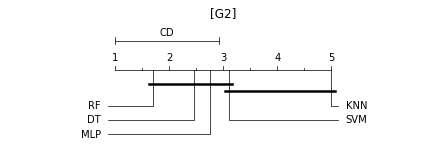

In [22]:
df_score_G2_class = friedman_nemenyi_tests_class(df_metrics_G2_class, "[G2]")

### Combinação [G1, G2]

#### Busca dos melhores modelos

In [23]:
X = base_class.drop(columns = ['G3']).to_numpy()
df_metrics_G1_G2_class = search_class(X,y,n_splits,random_state,algorithms_class)

##### Performance dos modelos

In [24]:
df_metrics_G1_G2_class

,MLP,SVM,KNN,DT,RF
0,0.923077,0.876923,0.861538,0.923077,0.923077
1,0.892308,0.938462,0.846154,0.938462,0.923077
2,0.892308,0.923077,0.861538,0.892308,0.923077
3,0.892308,0.923077,0.861538,0.923077,0.923077
4,0.892308,0.892308,0.815385,0.861538,0.938462
5,0.876923,0.846154,0.815385,0.876923,0.892308
6,0.923077,0.907692,0.846154,0.907692,0.969231
7,0.907692,0.923077,0.861538,0.938462,0.969231
8,0.953846,0.938462,0.830769,0.938462,0.953846
9,0.921875,0.890625,0.890625,0.921875,0.937500


In [25]:
df_metrics_G1_G2_class.mean()

MLP    0.907572
SVM    0.905986
KNN    0.849062
DT     0.912188
RF     0.935288
dtype: float64

In [26]:
df_metrics_G1_G2_class.std()

MLP    0.022847
SVM    0.029507
KNN    0.023499
DT     0.027134
RF     0.023822
dtype: float64

#### Teste de Friedman e Nemenyi (se necessário)

Statistics=27.099, p=1.89843e-05
Different distributions (reject H0)


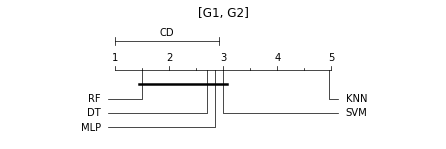

In [27]:
df_score_G1_G2_class = friedman_nemenyi_tests_class(df_metrics_G1_G2_class, "[G1, G2]")